In [ ]:
import os
import tensorflow as tf
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from ipynb.fs.full.preProcess import basic_preProcess, category_preProcess
from sklearn.cluster import KMeans

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Activation,Dropout,Lambda,Dense,Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import EarlyStopping


from keras.utils.vis_utils import plot_model

In [ ]:
# For Google Colab:
# from google.colab import drive
# drive.mount('/content/drive')

# train_dir = '/content/drive/MyDrive/Data/train'
# test_dir = '/content/drive/MyDrive/Data/test'
# train_df = pd.read_csv('/content/drive/MyDrive/Data/train.csv')

In [ ]:
# For Local File:
train_dir = './train/'
test_dir = './test/'
train_df = pd.read_csv('./train.csv')

In [ ]:
train_data_category = []

train_jenis = []
train_warna =[]

test_data = []
test_ids = []

"""
1. train_data_category: Menyimpan gambar data latih yang telah diproses dengan pemrosesan kategori.
2. train_jenis: Menyimpan label jenis untuk setiap gambar latih.
3. train_warna: Menyimpan label warna untuk setiap gambar latih.
4. test_data: Menyimpan data gambar uji (bagian ini tidak digunakan dalam kode ini tetapi diinisialisasi).
5. test_ids: Menyimpan ID untuk setiap gambar uji (juga tidak digunakan dalam kode ini tetapi diinisialisasi).
6. input_shape: Mendefinisikan ukuran standar input gambar sebagai (224, 224, 3).
"""

input_shape = (224, 224, 3)
for i in os.listdir(train_dir):
    if(i is not None):
        img_path = os.path.join(train_dir, i)
        img = cv.imread(img_path)
        if(img is not None):

          img_ca = img.copy()
          img_co = img.copy()
          img_category = category_preProcess(img_ca)
          img_category_output = basic_preProcess(img_category)

          train_data_category.append(img_category_output)

          cond = train_df['id'] == int(i[:-4])
          idx = train_df.loc[cond].index[0]
          train_jenis.append(train_df.iloc[idx]['jenis'])
          train_warna.append(train_df.iloc[idx]['warna'])

        else:
          print("no image found")

"""
Loop Pemrosesan Data Latih
Bagian ini melakukan iterasi pada setiap file di dalam direktori train_dir:

Memuat Gambar:
Path gambar dibuat menggunakan os.path.join(train_dir, i).
Gambar dimuat dengan cv.imread(img_path).
Jika gambar ditemukan (img is not None), gambar disalin menjadi img_ca dan img_co.

Pemrosesan Kategori:
img_category adalah hasil pemrosesan kategori dengan fungsi category_preProcess(img_ca).
img_category_output adalah gambar yang telah diproses melalui basic_preProcess(img_category).
Gambar hasil pemrosesan ini kemudian disimpan dalam train_data_category.

Pengambilan Label:
cond = train_df['id'] == int(i[:-4]) menentukan baris di train_df yang sesuai dengan ID gambar saat ini.
idx digunakan untuk mengambil baris dari train_df berdasarkan kondisi cond.
train_jenis menyimpan label jenis dari gambar, dan train_warna menyimpan label warna sesuai dengan data pada train_df.
Pesan Kesalahan:

Jika gambar tidak ditemukan (img is None), pesan "no image found" akan dicetak.
"""

xtrain_jenis, xval_jenis, ytrain_jenis, yval_jenis = train_test_split(
    train_data_category, train_jenis,
    test_size=0.2, random_state=42,
    stratify=train_jenis
)

"""
Pembagian Data Latih dan Validasi
Bagian ini membagi data latih menjadi dua bagian: data pelatihan (xtrain_jenis, ytrain_jenis) dan data validasi (xval_jenis, yval_jenis).

train_test_split menggunakan test_size=0.2, yang berarti 20% data akan digunakan sebagai data validasi.
stratify=train_jenis memastikan bahwa proporsi label jenis di data pelatihan dan data validasi tetap seimbang.
random_state=42 memastikan bahwa pembagian data ini dapat direproduksi dengan hasil yang sama setiap kali dijalankan.
"""

In [1]:
input_shape = (224, 224, 3)

"""
Inisialisasi Variabel input_shape
input_shape = (224, 224, 3): Mendefinisikan bentuk input gambar dengan ukuran (224, 224, 3),
yang berarti gambar memiliki lebar 224 piksel, tinggi 224 piksel, dan 3 saluran warna (RGB).
"""

num_classes_jenis = len(np.unique(train_jenis))
num_classes_warna = len(np.unique(train_warna))

"""
Menghitung Jumlah Kelas
Bagian ini menghitung jumlah kelas unik untuk label jenis dan warna dalam data latih:

num_classes_jenis: Menyimpan jumlah kelas unik dalam train_jenis.
num_classes_warna: Menyimpan jumlah kelas unik dalam train_warna.
"""

train_warna_categorical = to_categorical(train_warna, num_classes=num_classes_warna)
train_jenis_categorical = to_categorical(train_jenis, num_classes=num_classes_jenis)

"""
Konversi Label ke Bentuk Kategori
Bagian ini mengonversi label numerik train_warna, train_jenis, ytrain_jenis, dan yval_jenis menjadi bentuk kategori:

train_warna_categorical dan train_jenis_categorical: Masing-masing mengonversi train_warna dan train_jenis menjadi representasi one-hot dengan jumlah kelas sesuai dengan num_classes_warna dan num_classes_jenis.
"""

ytrain_jenis = to_categorical(ytrain_jenis, num_classes=num_classes_jenis)
yval_jenis = to_categorical(yval_jenis, num_classes=num_classes_jenis)

"""
ytrain_jenis dan yval_jenis: Masing-masing mengonversi ytrain_jenis dan yval_jenis ke bentuk satu-hot sesuai jumlah kelas num_classes_jenis.
"""

xtrain_jenis = np.array(xtrain_jenis)
xval_jenis = np.array(xval_jenis)

"""
Konversi Data Latih dan Validasi Menjadi Numpy Array
Bagian ini mengubah data latih dan data validasi (xtrain_jenis dan xval_jenis) menjadi numpy array agar kompatibel dengan input model.
"""

inp_color = Input(shape=input_shape)
inp_category = Input(shape=input_shape)

"""
Definisi Input untuk Model
Bagian ini mendefinisikan bentuk input untuk model:

inp_color: Digunakan untuk input gambar dengan kategori warna.
inp_category: Digunakan untuk input gambar dengan kategori jenis.
"""

print("Color model categorical labels (train_warna_categorical):", train_warna_categorical)
print("Jenis model categorical labels (train_jenis_categorical):", train_jenis_categorical)


NameError: name 'np' is not defined

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,include_top=False,weights='imagenet')
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

"""
Inisialisasi Model Dasar (Base Model)
Bagian ini melakukan langkah-langkah berikut:

Model Dasar: base_model adalah MobileNetV2 yang telah dilatih sebelumnya dengan bobot dari dataset ImageNet. Model ini dimuat tanpa lapisan output (menggunakan include_top=False), sehingga hanya digunakan untuk ekstraksi fitur.
Pengaturan Fine-Tuning:
base_model.trainable = True mengizinkan fine-tuning pada model dasar.
fine_tune_at = 100 menetapkan bahwa hanya lapisan di atas indeks 100 yang akan dilatih ulang. Lapisan-lapisan sebelum fine_tune_at (dari lapisan 0 hingga 99) dibekukan (trainable = False) untuk menjaga bobot awal dari model yang dilatih pada ImageNet.
"""

def create_model_jenis(num_classes_jenis):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Feature extraction layer
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    # Category branch
    category_output = layers.Dense(num_classes_jenis, activation='softmax', name='category_output')(x)

    model = Model(inputs=base_model.input, outputs=category_output)
    return model

"""
Fungsi create_model_jenis
Fungsi create_model_jenis membuat model untuk klasifikasi jenis dengan tahapan sebagai berikut:

Lapisan Ekstraksi Fitur: Menggunakan output dari base_model sebagai input untuk layers.GlobalAveragePooling2D(), yang menghasilkan representasi global rata-rata dari fitur gambar.
Cabang Kategori (category_output):
category_output adalah lapisan Dense dengan jumlah neuron sesuai dengan jumlah kelas jenis, yang dinyatakan dengan parameter num_classes_jenis.
Aktivasi softmax digunakan untuk menghasilkan probabilitas dari setiap kelas jenis.
Membangun Model: Model akhir dibuat dengan input dari base_model.input dan output dari category_output. Fungsi mengembalikan model yang sudah siap untuk dilatih.
"""

In [ ]:
category_model = create_model_jenis(num_classes_jenis)

"""
Kode ini memanggil fungsi create_model_jenis untuk membuat model klasifikasi kategori jenis dengan jumlah kelas yang ditentukan oleh num_classes_jenis. Fungsi create_model_jenis menggunakan MobileNetV2 sebagai model dasar (pre-trained) dan menambahkan lapisan klasifikasi dengan aktivasi softmax untuk menghasilkan prediksi kelas.
category_model: Variabel ini menyimpan model hasil dari create_model_jenis, yang siap digunakan untuk proses pelatihan dan klasifikasi jenis pada data gambar.
"""

In [ ]:
opt = Adam(learning_rate=0.00003)

"""
Optimizer Adam
Bagian ini menginisialisasi optimizer Adam dengan learning_rate=0.00003. Optimizer ini akan digunakan untuk mengupdate bobot model selama pelatihan.
"""

category_model.compile(optimizer=opt, loss='categorical_crossentropy',
	metrics=['accuracy'])

"""
Kompilasi Model
Bagian ini mengkompilasi category_model dengan:

optimizer=opt: Optimizer Adam yang didefinisikan sebelumnya.
loss='categorical_crossentropy': Fungsi loss yang digunakan untuk klasifikasi kategori multiclass.
metrics=['accuracy']: Metode pengukuran yang digunakan untuk menilai performa model adalah akurasi.
"""

history = category_model.fit(xtrain_jenis,ytrain_jenis, batch_size= 16, epochs=100,validation_data=(xval_jenis,yval_jenis))

"""
Pelatihan Model
Bagian ini melatih model menggunakan metode fit dengan parameter sebagai berikut:

xtrain_jenis dan ytrain_jenis: Data gambar dan label untuk data latih.
batch_size=16: Ukuran batch, yaitu jumlah sampel yang dilatih dalam sekali iterasi, adalah 16.
epochs=100: Jumlah epoch (putaran penuh melalui dataset) adalah 100.
validation_data=(xval_jenis, yval_jenis): Data validasi untuk mengevaluasi performa model pada akhir setiap epoch.
Variabel history menyimpan riwayat pelatihan, termasuk metrik seperti akurasi dan loss pada data latih dan validasi, yang dapat digunakan untuk analisis lebih lanjut.
"""


Epoch 1/100
39/39 [==============================] - 7s 80ms/step - loss: 0.4490 - accuracy: 0.7810 - val_loss: 0.5045 - val_accuracy: 0.7115
Epoch 2/100
39/39 [==============================] - 3s 69ms/step - loss: 0.1358 - accuracy: 0.9646 - val_loss: 0.3819 - val_accuracy: 0.7949
Epoch 3/100
39/39 [==============================] - 3s 68ms/step - loss: 0.0861 - accuracy: 0.9855 - val_loss: 0.3665 - val_accuracy: 0.8269
Epoch 4/100
39/39 [==============================] - 3s 66ms/step - loss: 0.0595 - accuracy: 0.9871 - val_loss: 0.3605 - val_accuracy: 0.8205
Epoch 5/100
39/39 [==============================] - 3s 65ms/step - loss: 0.0541 - accuracy: 0.9871 - val_loss: 0.3125 - val_accuracy: 0.8782
Epoch 6/100
39/39 [==============================] - 3s 65ms/step - loss: 0.0215 - accuracy: 0.9984 - val_loss: 0.3047 - val_accuracy: 0.8846
Epoch 7/100
39/39 [==============================] - 3s 67ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.2877 - val_accuracy: 0.8974
Epoch 

20/20 [==============================] - 1s 29ms/step - loss: 2.0625e-06 - accuracy: 1.0000
Loss and metrics for each output: [2.0625177512556547e-06, 1.0]
Total Test Loss: 2.0625177512556547e-06
Category Accuracy: 1.0
5/5 [==============================] - 0s 31ms/step - loss: 0.1979 - accuracy: 0.9615
Loss and metrics for each output: [0.19790980219841003, 0.9615384340286255]
Total Vall Loss: 0.19790980219841003
Val Category Accuracy: 0.9615384340286255


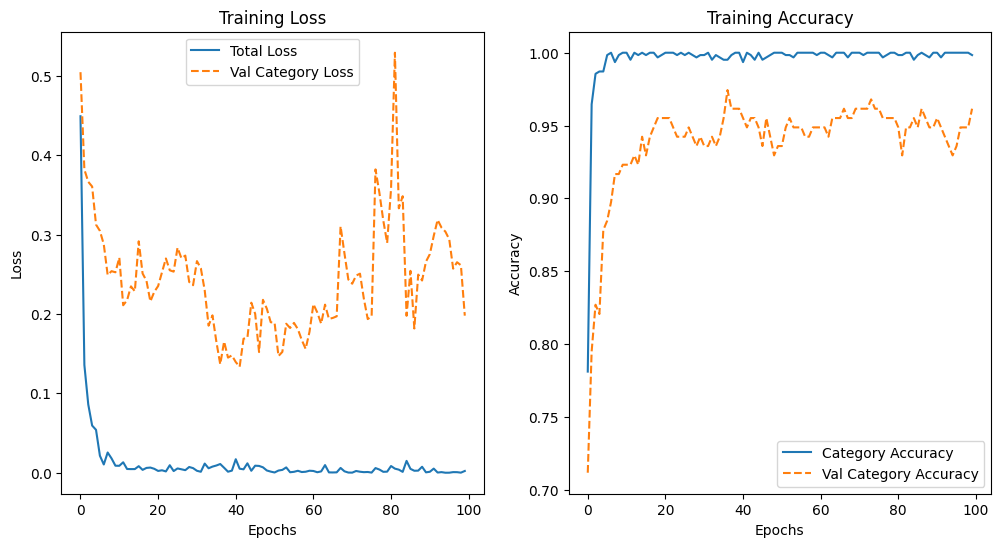

In [ ]:
# View Category Model Metrics
score = category_model.evaluate(xtrain_jenis,ytrain_jenis)
print("Loss and metrics for each output:", score)
print('Total Test Loss:', score[0])
print('Category Accuracy:', score[1])

"""
Evaluasi Model pada Data Latih
Bagian ini mengevaluasi category_model pada data latih (xtrain_jenis dan ytrain_jenis):

score[0]: Menampilkan total loss pada data latih.
score[1]: Menampilkan akurasi kategori pada data latih.
"""

score = category_model.evaluate(xval_jenis,yval_jenis)
print("Loss and metrics for each output:", score)
print('Total Vall Loss:', score[0])
print('Val Category Accuracy:', score[1])

"""
Bagian ini mengevaluasi category_model pada data validasi (xval_jenis dan yval_jenis):

score[0]: Menampilkan total loss pada data validasi.
score[1]: Menampilkan akurasi kategori pada data validasi.
"""

totall = len(history.history['loss'])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(totall), history.history['loss'], label='Total Loss')
plt.plot(range(totall), history.history['val_loss'], label='Val Category Loss', linestyle='--')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

"""
Bagian ini memvisualisasikan perubahan loss selama pelatihan:

history.history['loss']: Menampilkan total loss pada data latih untuk setiap epoch.
history.history['val_loss']: Menampilkan total loss pada data validasi untuk setiap epoch.
Grafik ini menampilkan kurva loss dengan garis solid untuk data latih dan garis putus-putus untuk data validasi.
"""

plt.subplot(1, 2, 2)
plt.plot(range(totall), history.history['accuracy'], label='Category Accuracy')

plt.plot(range(totall), history.history['val_accuracy'], label='Val Category Accuracy', linestyle='--')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.show()

"""
Bagian ini memvisualisasikan akurasi selama pelatihan:

history.history['accuracy']: Menampilkan akurasi kategori pada data latih untuk setiap epoch.
history.history['val_accuracy']: Menampilkan akurasi kategori pada data validasi untuk setiap epoch.
Grafik ini menampilkan kurva akurasi dengan garis solid untuk data latih dan garis putus-putus untuk data validasi.

"""

In [ ]:
category_model.save('./models/category.h5', include_optimizer=True)

"""
Kode ini menyimpan model category_model ke dalam file dengan format HDF5 (.h5). Proses penyimpanan mencakup semua informasi penting tentang model, seperti arsitektur, bobot, dan konfigurasi optimizer.

category_model.save(...): Fungsi ini digunakan untuk menyimpan model.
'./models/category.h5': Menentukan lokasi dan nama file tempat model akan disimpan. Dalam hal ini, model akan disimpan dalam folder models dengan nama category.h5.
include_optimizer=True: Parameter ini memastikan bahwa informasi tentang optimizer juga disimpan bersama model. Ini memungkinkan pemulihan model yang lebih mudah dan melanjutkan pelatihan jika diperlukan.
Dengan menyimpan model, pengguna dapat dengan mudah memuatnya kembali di lain waktu tanpa harus melatih ulang, sehingga menghemat waktu dan sumber daya.
"""